<a href="https://colab.research.google.com/github/compressed-sensing/algorithms/blob/development/notebooks/Adaptive_TV_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TV Denoising with Adaptive learning rate


## Import libraries

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy.signal as signal
from scipy.signal import convolve2d
import scipy.fft as fft
import urllib.request
from skimage.metrics import peak_signal_noise_ratio as PSNR
import time

## Import image

<class 'numpy.ndarray'>
(512, 512)


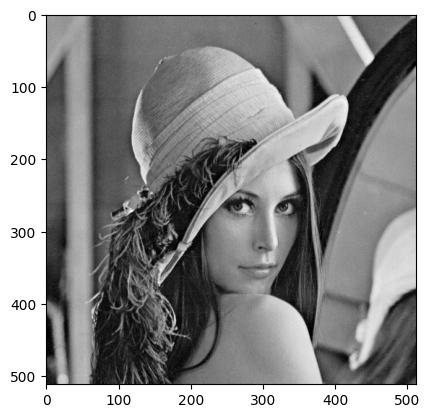

In [2]:
# Reading image (grayscale)
url = 'https://i.stack.imgur.com/kP0u2.png'
  # url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSRsK5QFJ1arEQlnHEJ-020xbO30BgdYgPJBg&usqp=CAU'
  #url='https://unsplash.com/photos/IoZA1Mwiq2g/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTZ8fGJsYWNrJTIwYW5kJTIwd2hpdGUlMjBmbG93ZXJ8ZW58MHx8fHwxNjc5MzQxODY4&force=true&w=640'
with urllib.request.urlopen(url) as url_response:
  img_array = np.asarray(bytearray(url_response.read()), dtype=np.uint8)
  img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
# img is a 3-dimensional numpy array (third number indicates channel)
# Converting to (0,1)
x = img.astype(float)/255.
print(type(img)) 
print(img.shape) 
plt.imshow(x, cmap ='gray')

## Define conv and fft functions

In [3]:
# Define some of the operators that we need...
def conv2d_fft(x, h):
     p0 = x.shape[0]-h.shape[0]
     p1 = x.shape[1]-h.shape[1]
     h_pad = np.pad(h, ((0,p0),(0,p1)))
     Fh = fft.fft2(h_pad)
     Fx = fft.fft2(x)
     return np.real(fft.ifft2(Fx*Fh))

def conv2dT_fft(x, h):
     p0 = x.shape[0]-h.shape[0]
     p1 = x.shape[1]-h.shape[1]
     h_pad = np.pad(h, ((0,p0),(0,p1)))
     Fh = fft.fft2(h_pad)
     Fx = fft.fft2(x)
     return np.real(fft.ifft2(Fx*np.conj(Fh)))

## Noise function

In [4]:
def awgn(img,n):
  ''' Generating Gaussian Noise 
      with 0 mean and standard deviation n 
      choose n between 0,1 for normalized image '''

  noise = np.random.randn(*img.shape)*n
  # Add the noise to the input image
  noisy_image = img + noise

  return noisy_image

## Add noise to the image

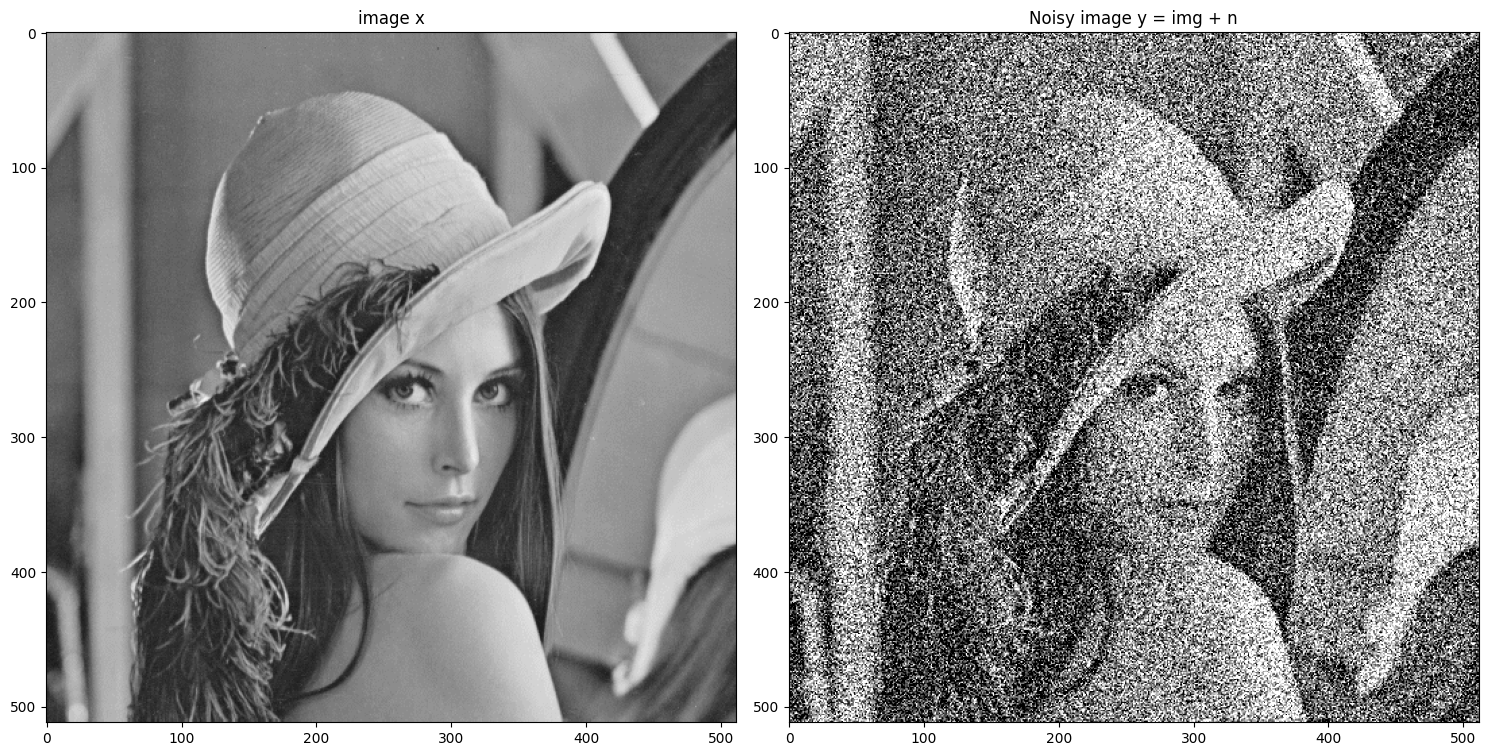

In [21]:
'''
y1 = img + n
'''
# Add noise to the image
y1 = awgn(x,0.4)

fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(x, cmap='gray', clim=[0,1])
plt.title('image x')
plt.subplot(122)
plt.imshow(y1, cmap='gray', clim=[0,1])
plt.title('Noisy image y = img + n')
plt.tight_layout()
plt.show()

## Gradiant operator

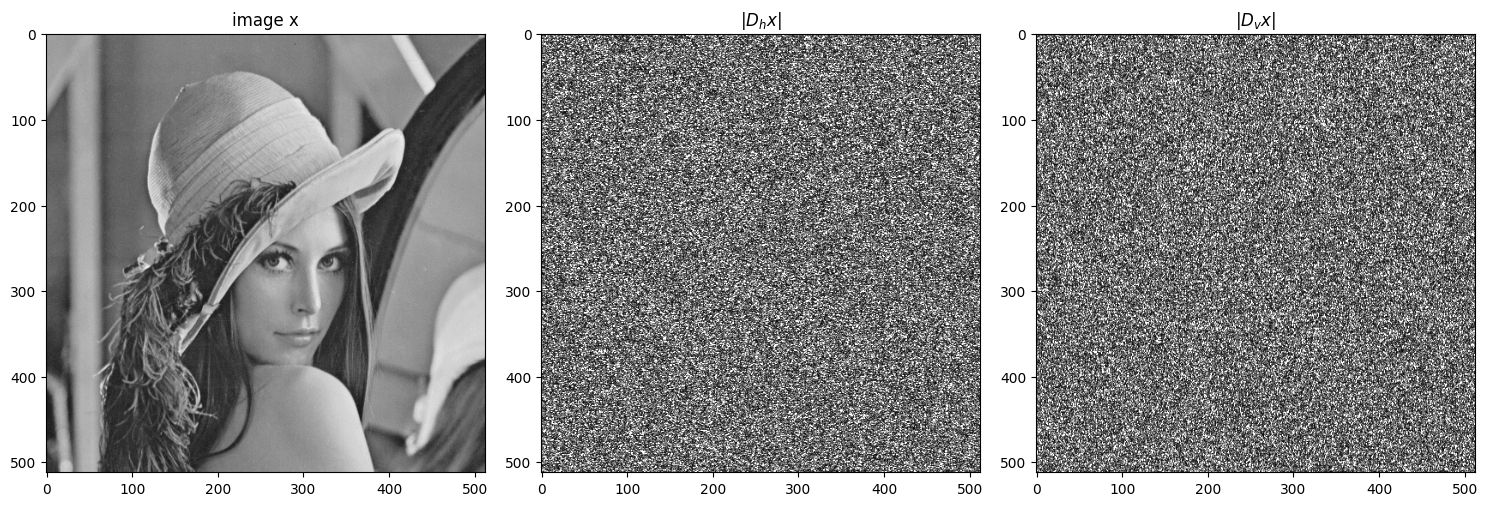

In [22]:
# define gradient operators
'''
I am testing it with y1 for now
'''
dh = np.array([[1,-1],[0, 0]]) # horizontal gradient filter
dv = np.array([[1, 0],[-1,0]]) # vertical gradient filter

Dh = lambda x: conv2d_fft(x, dh)
Dv = lambda x: conv2d_fft(x, dv)

DhT = lambda x: conv2dT_fft(x, dh)
DvT = lambda x: conv2dT_fft(x, dv)

# plot the image x and the gradient images Dh x and Dv x
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(x, cmap='gray', clim=[0,1])
plt.title('image x')
plt.subplot(132)
plt.imshow(np.abs(Dh(y1)), cmap='gray', clim=[0,1])
plt.title(r'$|D_hx|$')
plt.subplot(133)
plt.imshow(np.abs(Dv(y1)), cmap='gray', clim=[0,1])
plt.title(r'$|D_vx|$')
plt.tight_layout()
plt.show()

In [23]:
class StepDecay:
    def __init__(self, initial_lr, drop_rate, epochs_per_drop):
        self.initial_lr = initial_lr
        self.drop_rate = drop_rate
        self.epochs_per_drop = epochs_per_drop
        
    def __call__(self, epoch):
        lr = self.initial_lr * self.drop_rate**(np.floor(epoch/self.epochs_per_drop))
        return lr

In [24]:
class ExpDecay:
    def __init__(self, initial_lr, decay_rate, decay_steps):
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        
    def __call__(self, epoch):
        lr = self.initial_lr * self.decay_rate**(epoch/self.decay_steps)
        return lr

## TV-denoising Solver
Write TV-denoising formulation with explanation here later

In [25]:
def TV_denoising(y, lamb = 2, rho=1e1, maxiter=200, decay=None):
    '''
    TV-denoising solver to solve
    minimize 0.5 |x-y|_2^2 + lambda|Dx|_1
    '''
    # define the soft-thresholding function
    '''
    In the TVD case we have : 
    Vector (v): Dx_(k+1) + u_(k)
    Threshold (t): lamb/rho
    '''
    start = time.time()
    soft_thresh = lambda v, t: np.maximum(np.abs(v)-t, 0.)*np.sign(v)
    
    # DDT
    '''
        DDT = please check notes for fourier transform format
    '''
    # Calculating the difference between sizes x and d for padding purpose
    p0 = x.shape[0]-dh.shape[0]
    p1 = x.shape[1]-dh.shape[1]
    dh_pad = np.pad(dh, ((0,p0),(0,p1)))
    
    p0 = x.shape[0]-dv.shape[0]
    p1 = x.shape[1]-dv.shape[1]
    dv_pad = np.pad(dv, ((0,p0),(0,p1)))
    
    # Refer to Parisima's notes for computing DDT using FFT
    DDT = np.abs(fft.fft2(dh_pad))**2 +\
          np.abs(fft.fft2(dv_pad))**2

# -----------------------------
    # initilize iteration variables
    zh = np.zeros_like(y)
    zv = np.zeros_like(y)
    uh = np.zeros_like(zh)
    uv = np.zeros_like(zv)
    x_hat = np.zeros_like(y)
    # For computing error
    J = np.zeros(maxiter)

    for k in range(maxiter):
        # solve the L2-L2 problem (update x) 
        rhs = y + rho * (DhT(zh) + DvT(zv)) - DhT(uh) - DvT(uv)
        F_rhs = fft.fft2(rhs)
        x_hat = np.real(fft.ifft2(F_rhs/(rho * DDT + 1)))

        # solve the TV problem (update z)
        zh = soft_thresh(Dh(x_hat)+ uh, lamb/rho)
        zv = soft_thresh(Dv(x_hat)+ uv, lamb/rho)

        # update u
        dual_h = Dh(x_hat) - zh
        dual_v = Dv(x_hat) - zv
        uh = uh + dual_h
        uv = uv + dual_v

        # compute the error
        J[k] = (dual_h**2).sum()+(dual_v**2).sum()

        if decay is not None:
          lamb = decay(k)
    end = time.time()
    return x_hat, J, end-start

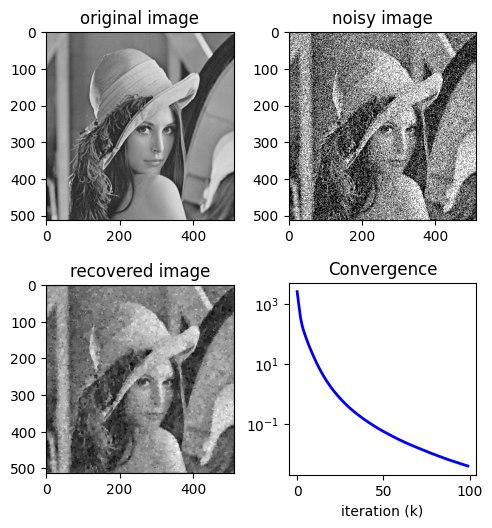

Time taken = 17.788549184799194


In [74]:
lamb = 0.5
maxiter = 100
rho = 2
x_hat, J, duration = TV_denoising(y1, lamb = lamb, rho=rho, maxiter=maxiter, decay=None)

fig = plt.figure()
fig.set_size_inches(5,7.5)
ax = fig.add_subplot(321)
ax.imshow(x, cmap='gray', clim=[0,1])
plt.title('original image')
ax2 = fig.add_subplot(322)
ax2.imshow(y1, cmap='gray', clim=[0,1])
plt.title('noisy image')
ax3 = fig.add_subplot(323)
ax3.imshow(x_hat, cmap='gray', clim=[0,1])
plt.title('recovered image')
ax4 = fig.add_subplot(324)
ax4.semilogy(range(len(J)), J, 'b-', lw=2)
plt.title('Convergence')
plt.xlabel('iteration (k)')
plt.tight_layout()
plt.show()
print(f"Time taken = {duration}")


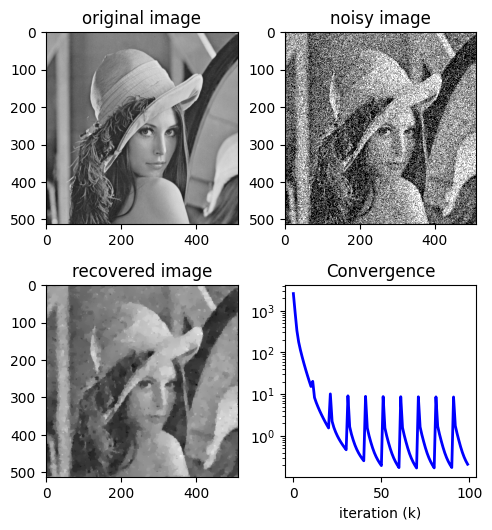

Time taken = 21.324676752090454


In [55]:
step_decay = StepDecay(initial_lr=lamb, drop_rate=1.03, epochs_per_drop=10)
x_hat_step, J_step, duration = TV_denoising(y1, lamb = lamb, rho=rho, maxiter=maxiter, decay=step_decay)

fig = plt.figure()
fig.set_size_inches(5,7.5)
ax = fig.add_subplot(321)
ax.imshow(x, cmap='gray', clim=[0,1])
plt.title('original image')
ax2 = fig.add_subplot(322)
ax2.imshow(y1, cmap='gray', clim=[0,1])
plt.title('noisy image')
ax3 = fig.add_subplot(323)
ax3.imshow(x_hat_step, cmap='gray', clim=[0,1])
plt.title('recovered image')
ax4 = fig.add_subplot(324)
ax4.semilogy(range(len(J_step)), J_step, 'b-', lw=2)
plt.title('Convergence')
plt.xlabel('iteration (k)')
plt.tight_layout()
plt.show()
print(f"Time taken = {duration}")

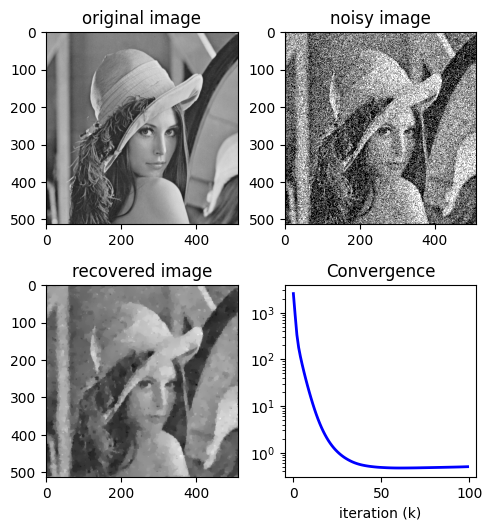

Time taken = 20.138094902038574


In [56]:
exp_decay = ExpDecay(initial_lr=lamb, decay_rate=1.03, decay_steps=10)
x_hat_exp, J_exp, duration = TV_denoising(y1, lamb = lamb, rho=rho, maxiter=maxiter, decay=exp_decay)

fig = plt.figure()
fig.set_size_inches(5,7.5)
ax = fig.add_subplot(321)
ax.imshow(x, cmap='gray', clim=[0,1])
plt.title('original image')
ax2 = fig.add_subplot(322)
ax2.imshow(y1, cmap='gray', clim=[0,1])
plt.title('noisy image')
ax3 = fig.add_subplot(323)
ax3.imshow(x_hat_exp, cmap='gray', clim=[0,1])
plt.title('recovered image')
ax4 = fig.add_subplot(324)
ax4.semilogy(range(len(J_exp)), J_exp, 'b-', lw=2)
plt.title('Convergence')
plt.xlabel('iteration (k)')
plt.tight_layout()
plt.show()
print(f"Time taken = {duration}")

In [57]:
list_of_imgs = [x, y1, x_hat, x_hat_step, x_hat_step]
list_of_titles = ['original', 'noisy', 'TVD', 'TVD with step decay', 'TVD with exp decay']


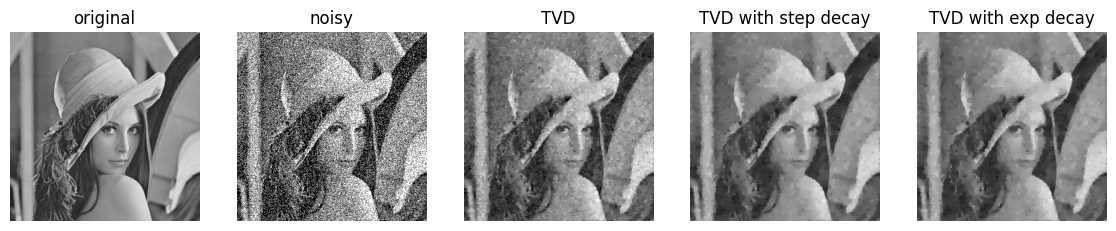

In [67]:

fig = plt.figure(figsize=(20,20))
for i,img in enumerate(list_of_imgs):
  plt.subplot(1,7,i+1)
  plt.axis('off')
  plt.imshow(img, cmap='gray', clim=[0,1])
  plt.title(list_of_titles[i])


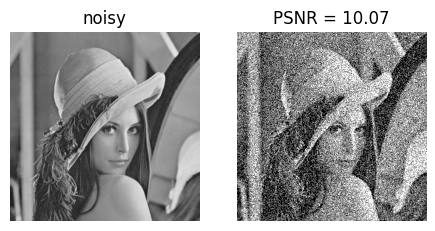

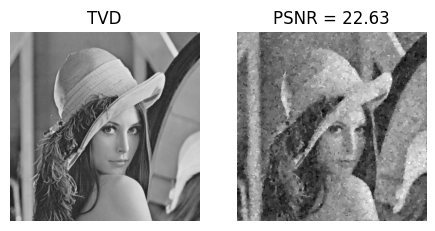

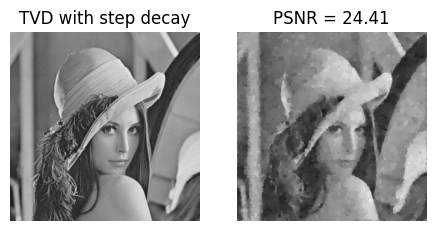

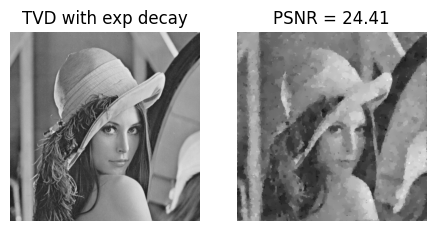

In [73]:

for i,img in enumerate(list_of_imgs[1:]):
  fig = plt.figure(figsize=(20,20))
  plt.subplot(1,7,1)
  plt.title(list_of_titles[i+1])
  plt.axis('off')
  plt.imshow(x, cmap='gray', clim=[0,1])
  plt.subplot(1,7,2)
  plt.axis('off')
  plt.imshow(img, cmap='gray', clim=[0,1])
  plt.title(f"PSNR = {PSNR(x.clip(0,1), img.clip(0,1)):.2f}")
  